In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
# matplotlib.use("TkAgg")
%matplotlib tk
import matplotlib.pyplot as plt

## 2D dataset

In [3]:
num_points = 100
X1 = np.linspace(-2.5, 1.9, num_points)
# X1 = np.linspace(-2.5, 2.5, num_points)
# X2 = np.linspace(-2.5, 3, num_points)
X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
Y = Y/2

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))


In [4]:
# %matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
from convex_lib import ConvexNN

In [6]:
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm
import nflib.res_flow as irf
import nflib

In [7]:
class DistanceRegressor(nn.Module):
    def __init__(self, input_dim, inv_temp=1):
        super().__init__()
        self.centers = nn.Parameter(torch.rand(1, input_dim)*2-1)
        self.bias = nn.Parameter(torch.ones(1)*-0.5)
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)

        
    def forward(self, x):
        x = torch.norm(x-self.centers, dim=-1, keepdim=True)
#         x = -x*self.inv_temp + self.bias
        x = x*self.inv_temp + self.bias
        return x

In [8]:
EPOCHS = 1000
actf = nn.LeakyReLU
# actf = nn.ELU
learning_rate = 0.005
criterion = nn.MSELoss()

# Invex NN

In [9]:
# cvxNet = ConvexNN([2, 10, 10, 1], actf)

cvxNet = nn.Sequential(
    nn.BatchNorm1d(2),
    irf.ResidualFlow(2, [10]),
    nn.BatchNorm1d(2),
    DistanceRegressor(2),
)


optimizer = torch.optim.Adam(cvxNet.parameters(), lr=learning_rate)

In [10]:
%matplotlib tk
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

for epoch in range(EPOCHS):

    yout = -cvxNet(xx)    
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%100 == 0 or epoch==EPOCHS-1:
        print(f'Epoch: {epoch}, Loss:{float(loss)}')
        ax.clear()
        ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        ax2.clear()
        ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

Epoch: 0, Loss:2.4094741344451904
Epoch: 100, Loss:0.05086516588926315
Epoch: 200, Loss:0.020988821983337402
Epoch: 300, Loss:0.019115671515464783
Epoch: 400, Loss:0.018101464956998825
Epoch: 500, Loss:0.017071103677153587
Epoch: 600, Loss:0.01638054847717285
Epoch: 700, Loss:0.015930045396089554
Epoch: 800, Loss:0.015462301671504974
Epoch: 900, Loss:0.0151296341791749
Epoch: 999, Loss:0.014934229664504528


/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


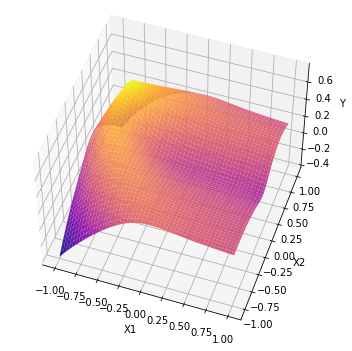

In [11]:
%matplotlib inline

y_ = yout.data.cpu().numpy().reshape(Y.shape)

fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.view_init(49, -71)
ax.plot_surface(X1, X2, y_, cmap='plasma', alpha=0.9)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
# plt.pause(0.1)
plt.show()

## Plotting Contour Plot

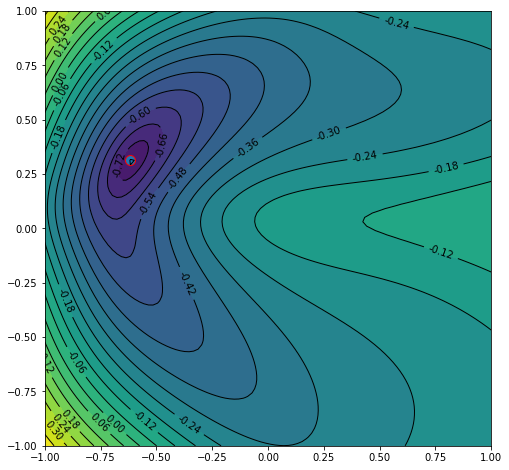

In [12]:
# LVLs = np.linspace(sim.min(), sim.max(), 20)
LVLs = 20

y_ = cvxNet(xx).data.cpu().numpy().reshape(Y.shape)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
minima = xx[y_.argmin()]
plt.scatter(*minima.tolist(), s=100, edgecolors="red")

In [13]:
min_val = y_.min()
min_val

-0.7838053

In [14]:
minima = xx[None, y_.argmin()]
minima

tensor([[-0.6162,  0.3131]])

In [15]:
# minima[0, 0] = minima[0, 0] + 0.25
# minima[0, 1] = minima[0, 1] - 0.1

## Finding Mimima by using gradient descent

In [16]:
xmin = torch.randn_like(minima)
xmin = torch.autograd.Variable(xmin, requires_grad=True)
xmin

tensor([[-1.6269, -0.4221]], requires_grad=True)

In [17]:
optim = torch.optim.Adam([xmin], lr=0.001)
STEPS = 4000

In [18]:
cvxNet.eval()

Sequential(
  (0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ResidualFlow(
    (resblock): ModuleList(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): Swish()
      (2): Linear(in_features=10, out_features=2, bias=True)
    )
  )
  (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): DistanceRegressor()
)

### Search Loop

In [19]:
for step in range(STEPS):
    optimizer.zero_grad() 

    ymin = cvxNet(xmin)
    xgrad = torch.autograd.grad(outputs=ymin, inputs=xmin, grad_outputs=torch.ones_like(ymin), 
                            only_inputs=True, retain_graph=True, create_graph=True)[0]
    xmin.grad = xgrad
    
    optim.step()
    
    if step%100 == 0:
        print(f"STEPS: {step}, xmin: {xmin.data}, min_value: {ymin.data}")

STEPS: 0, xmin: tensor([[-1.6259, -0.4211]]), min_value: tensor([[1.0555]])
STEPS: 100, xmin: tensor([[-1.5258, -0.3207]]), min_value: tensor([[0.8427]])
STEPS: 200, xmin: tensor([[-1.4255, -0.2176]]), min_value: tensor([[0.6259]])
STEPS: 300, xmin: tensor([[-1.3250, -0.1117]]), min_value: tensor([[0.4041]])
STEPS: 400, xmin: tensor([[-1.2242, -0.0172]]), min_value: tensor([[0.1904]])
STEPS: 500, xmin: tensor([[-1.1234,  0.0419]]), min_value: tensor([[-0.0015]])
STEPS: 600, xmin: tensor([[-1.0234,  0.0708]]), min_value: tensor([[-0.1802]])
STEPS: 700, xmin: tensor([[-0.9260,  0.0905]]), min_value: tensor([[-0.3479]])
STEPS: 800, xmin: tensor([[-0.8339,  0.1166]]), min_value: tensor([[-0.4964]])
STEPS: 900, xmin: tensor([[-0.7516,  0.1642]]), min_value: tensor([[-0.6166]])
STEPS: 1000, xmin: tensor([[-0.6804,  0.2373]]), min_value: tensor([[-0.7121]])
STEPS: 1100, xmin: tensor([[-0.6139,  0.3077]]), min_value: tensor([[-0.7925]])
STEPS: 1200, xmin: tensor([[-0.6113,  0.3100]]), min_valu

In [20]:
xgrad

tensor([[ 1.3420, -0.9247]], grad_fn=<NativeBatchNormBackwardBackward>)

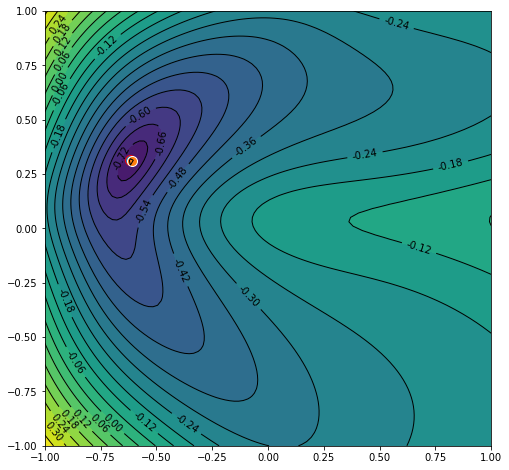

In [21]:
# LVLs = np.linspace(sim.min(), sim.max(), 20)
LVLs = 20

y_ = cvxNet(xx).data.cpu().numpy().reshape(Y.shape)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
minima = xx[y_.argmin()]
plt.scatter(*minima.tolist(), s=100, edgecolors="red")
plt.scatter(*xmin.data[0].tolist(), s=100, edgecolors="white")

In [22]:
minima = xmin.data
min_val = ymin.data[0].item()
minima, min_val

(tensor([[-0.6113,  0.3100]]), -0.7956867218017578)

## Using Learned function for Distance

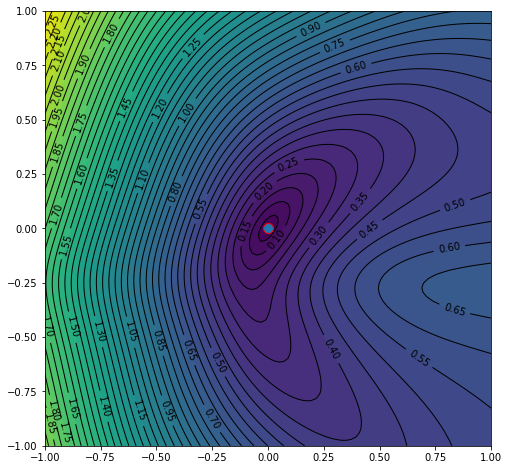

In [23]:
xx_ = xx + minima
y_ = cvxNet(xx_).data.cpu().numpy().reshape(Y.shape)- min_val
# y_ = y_**0.5

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
plt.scatter(0, 0, s=100, edgecolors="red")

## Getting the uniform growth in all direction

In [24]:
def get_contour_distance(level=1.0):
    xx_ =  xx
    x_norm = torch.norm(xx_, dim=1, keepdim=True)
    xx_= xx_/x_norm*level
    y_ = cvxNet(xx_+ minima) - min_val
#     print(cvxNet)
    y_ = y_*x_norm/level
    return y_

<a list of 58 text.Text objects>

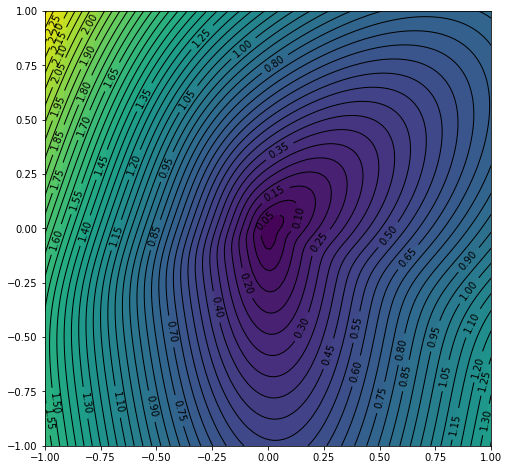

In [25]:
y_ = get_contour_distance(0.55).data.cpu().numpy().reshape(Y.shape)#**0.5

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
# plt.scatter(0, 0, s=100, edgecolors="red")

In [26]:
'''
Observation: -> for some minima
1) A general Invex function also seem to produce 1-invex distance function
'''

'\nObservation: -> for some minima\n1) A general Invex function also seem to produce 1-invex distance function\n'

### Extracting the Exact Contour 

In [27]:
"""
PROBLEM:
A. The contours generated by using convex function as a distance can produce non-convex contours.
B. Extracting the exact contours given a function is difficult (not made in such a way)


SOLUTION
Getting distance to a specific contour (a) in a given direction from the center. 
1. Make mimima at given (a) and optimize xx only in the magnitude. The final xx is the contour.
    a) initialize xx to unit-norm(or a) so that slight misplace in minima does not alter contour to (a)
2. distance = ||initial xx||  /  ||final xx||

BETTER -> get the exact 
"""

'\nPROBLEM:\nA. The contours generated by using convex function as a distance can produce non-convex contours.\nB. Extracting the exact contours given a function is difficult (not made in such a way)\n\n\nSOLUTION\nGetting distance to a specific contour (a) in a given direction from the center. \n1. Make mimima at given (a) and optimize xx only in the magnitude. The final xx is the contour.\n    a) initialize xx to unit-norm(or a) so that slight misplace in minima does not alter contour to (a)\n2. distance = ||initial xx||  /  ||final xx||\n\nBETTER -> get the exact \n'

In [80]:
xx.shape

torch.Size([10000, 2])

In [81]:
# minima_bkp = minima.data.clone()
# minima = minima_bkp - 0.1
# minima_bkp

In [82]:
# minima = minima_bkp

In [83]:
level = 0.35 # 0.65, 0.25
xx_norm = torch.norm(xx, dim=1, keepdim=True)
xx_ = xx/xx_norm * level

In [84]:
xx_lnorm = torch.ones_like(xx_norm)*0.5
xx_lnorm = torch.autograd.Variable(xx_lnorm, requires_grad=True)
xx_lnorm

tensor([[0.5000],
        [0.5000],
        [0.5000],
        ...,
        [0.5000],
        [0.5000],
        [0.5000]], requires_grad=True)

In [85]:
optim = torch.optim.Adam([xx_lnorm], lr=0.01, eps=1e-18)
STEPS = 4000

In [86]:
minima

tensor([[-0.7113,  0.2100]])

### Training Loop

In [87]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, STEPS)

In [89]:
for step in range(STEPS):
    optimizer.zero_grad() 

    yy_ = torch.abs(cvxNet(xx_*xx_lnorm + minima) - min_val - level)
    xgrad = torch.autograd.grad(outputs=yy_, inputs=xx_lnorm, grad_outputs=torch.ones_like(yy_), 
                            only_inputs=True, retain_graph=True, create_graph=True)[0]
    xx_lnorm.grad = xgrad
    
    optim.step()
    scheduler.step()
    
    if step%100 == 0:
        print(f"STEPS: {step}, norm_min: {xx_lnorm.data.min()}, norm_max: {xx_lnorm.data.max()}, min_value: {ymin.data.min()}")

STEPS: 0, norm_min: 0.4096249043941498, norm_max: 2.2195422649383545, min_value: -0.7956867218017578
STEPS: 100, norm_min: 0.407846599817276, norm_max: 2.2205309867858887, min_value: -0.7956867218017578
STEPS: 200, norm_min: 0.4086960554122925, norm_max: 2.2194910049438477, min_value: -0.7956867218017578
STEPS: 300, norm_min: 0.4095488488674164, norm_max: 2.220120906829834, min_value: -0.7956867218017578
STEPS: 400, norm_min: 0.4095001816749573, norm_max: 2.2197022438049316, min_value: -0.7956867218017578
STEPS: 500, norm_min: 0.41004234552383423, norm_max: 2.219667434692383, min_value: -0.7956867218017578
STEPS: 600, norm_min: 0.4099743962287903, norm_max: 2.220484972000122, min_value: -0.7956867218017578
STEPS: 700, norm_min: 0.4098360240459442, norm_max: 2.21956205368042, min_value: -0.7956867218017578
STEPS: 800, norm_min: 0.409004271030426, norm_max: 2.219958543777466, min_value: -0.7956867218017578
STEPS: 900, norm_min: 0.4089372158050537, norm_max: 2.21943998336792, min_value: -

In [ ]:
y_ = (xx_norm/xx_lnorm.data).cpu().reshape(X1.shape)

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

In [75]:
y_.shape

torch.Size([100, 100])

## Invex Function for refrence

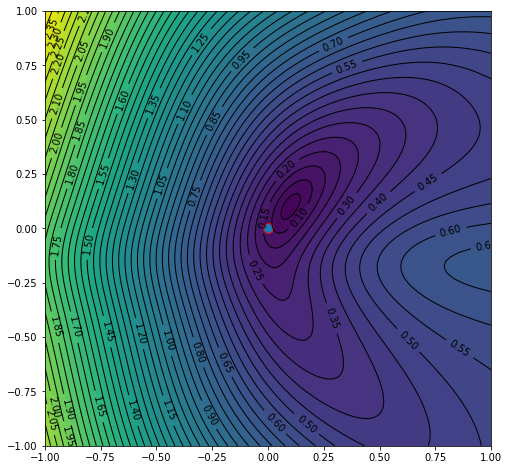

In [76]:
xx_ = xx + minima
y_ = cvxNet(xx_).data.cpu().numpy().reshape(Y.shape)- min_val
# y_ = y_**0.5

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
plt.scatter(0, 0, s=100, edgecolors="red")